# Regresion Lineal y Logistica

# Regresion Lineal

En este ejemplo intentaremos adivinar cuantos likes tiene un video de tiktok a partir de la cantidad de vistas

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:
# tiktok vistas y likes de distintos videos

views = [234_000, 8_000, 217_000, 25_000, 62_000, 107_000, 
         140_000, 191_000, 189_000, 496_000, 221_000, 238_000]
likes = [ 39_000,   362,  31_000,  1_500,  4_000,   5_000,   
           6_000,  15_000,  11_000,  30_000,  30_000,  31_000]

In [112]:
df = pd.DataFrame({"Views":views,"Likes":likes})

In [113]:
df.head()

,Views,Likes
0,234000,39000
1,8000,362
2,217000,31000
3,25000,1500
4,62000,4000


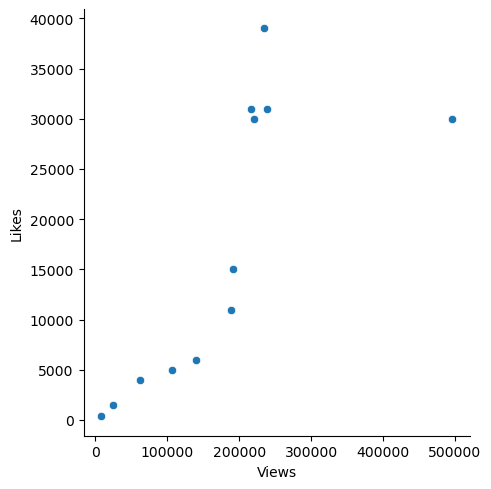

In [114]:
sns.relplot(x="Views",y="Likes", data=df);

## Regresion Lineal

Suponemos que la cantidad de likes es linealmente proporcional a la cantidad de vistas

In [115]:
#https://en.wikipedia.org/wiki/Simple_linear_regression
df["x - xmean"] = df["Views"] - df["Views"].mean()
df["y - ymean"] = df["Likes"] - df["Likes"].mean()
df["sq(x - xmean)"] = df["x - xmean"] * df["x - xmean"]

In [116]:
df.head()

,Views,Likes,x - xmean,y - ymean,sq(x - xmean)
0,234000,39000,56666.666667,22011.5,3.211111e+09
1,8000,362,-169333.333333,-16626.5,2.867378e+10
2,217000,31000,39666.666667,14011.5,1.573444e+09
3,25000,1500,-152333.333333,-15488.5,2.320544e+10
4,62000,4000,-115333.333333,-12988.5,1.330178e+10


In [117]:
w = np.sum(df["x - xmean"] * df["y - ymean"]) / df["sq(x - xmean)"].sum()

In [118]:
w

0.08269744274379914

In [119]:
b = np.mean(df["Likes"] - w * df["Views"])

In [120]:
b

2323.4868200996184

In [121]:
linea = lambda x: w * x + b

In [122]:
coef = np.polyfit(df["Views"],df["Likes"],1)
linea = np.poly1d(coef)
print(coef)
print(linea)

[8.26974427e-02 2.32348682e+03]
 
0.0827 x + 2323


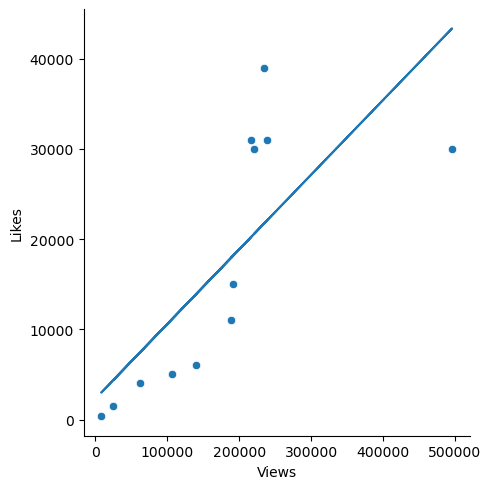

In [123]:
sns.relplot(x="Views",y="Likes", data=df)
plt.plot(df["Views"], linea(df["Views"]), '-');

## Usando la libreria Scikit Learn

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [133]:
from sklearn.linear_model import LinearRegression
X = df.loc[:,["Views"]]
y = df["Likes"]
reg = LinearRegression().fit(X, y)

In [134]:
reg.coef_

array([0.08269744])

In [135]:
reg.intercept_

2323.486820099617

## Parametros Polinomiales

Podemos generar nuevas columnas con x^2, x^3 y asi sucesivamente.

Si hay varias variables tambien podemos generar sus combinaciones, por ejemplo x*y

In [124]:
from sklearn.preprocessing import PolynomialFeatures
X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [125]:
poly = PolynomialFeatures(2)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [126]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.],
       [ 1.,  2.,  3.,  6.],
       [ 1.,  4.,  5., 20.]])

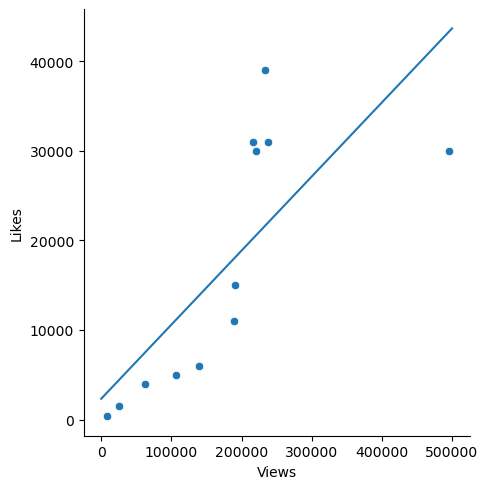

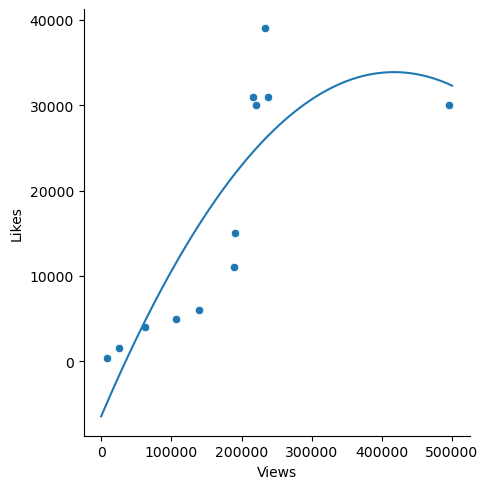

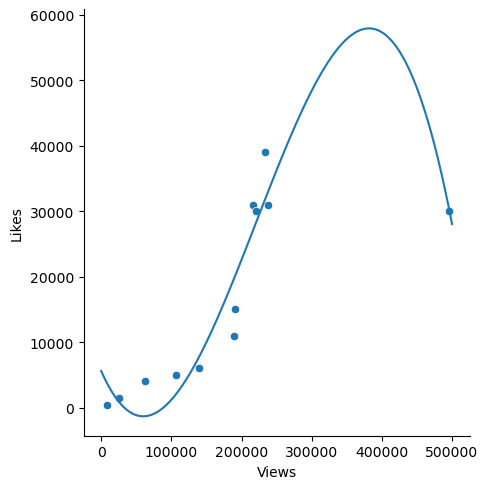

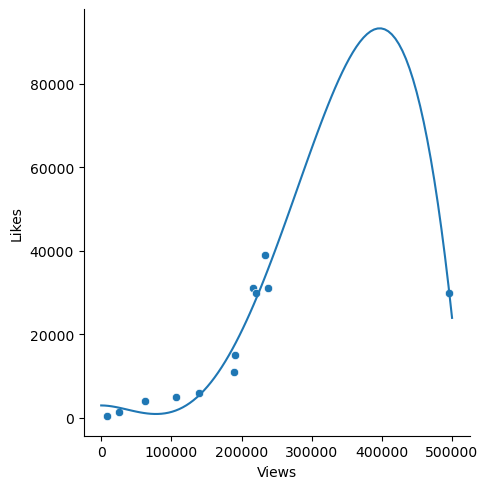

In [168]:
X = df.loc[:,["Views"]]
y = df["Likes"]
for p in [1,2,3,4]:
    poly = PolynomialFeatures(p)
    Xpoly = poly.fit_transform(X)
    reg = LinearRegression().fit(Xpoly, y)
    sns.relplot(x="Views",y="Likes", data=df)
    plotx = np.linspace(0,500_000,100)[...,None]
    plotxpoly = poly.fit_transform(plotx)
    plt.plot(plotx, reg.predict(plotxpoly), '-');

## Usando statsmodels 

https://www.statsmodels.org/stable/regression.html

In [170]:
import statsmodels.api as sm
x_train = df.loc[:,["Views"]]
y_train = df["Likes"]

In [176]:
# Agregar una constante
X = sm.add_constant(x_train)

# Crear el modelo de Ordinary Least Squares
model = sm.OLS(y_train, X)
res = reg.fit()

# Mostrar los parametros
b = res.params[0]
w = res.params[1]
print(f"b:{b} w:{w}")
print(res.summary())

b:2323.4868200996175 w:0.08269744274379917
                            OLS Regression Results                            
Dep. Variable:                  Likes   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     13.25
Date:                Mon, 12 Jun 2023   Prob (F-statistic):            0.00453
Time:                        09:19:49   Log-Likelihood:                -126.14
No. Observations:                  12   AIC:                             256.3
Df Residuals:                      10   BIC:                             257.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

/Users/hernanamiune/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# IA: adivinar y luego minimzar el error repetidamente

En este ejemplo intentaremos adivinar cuantos likes tiene un video de tiktok a partir de la cantidad de vistas

In [591]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [592]:
# tiktok vistas y likes de distintos videos
views = [234_000, 8_000, 217_000, 25_000, 62_000, 107_000, 
         140_000, 191_000, 189_000, 496_000, 221_000, 238_000]
likes = [ 39_000,   362,  31_000,  1_500,  4_000,   5_000,   
           6_000,  15_000,  11_000,  30_000,  30_000,  31_000]

In [593]:
df = pd.DataFrame({"Views":views,"Likes":likes})

In [594]:
df.head()

,Views,Likes
0,234000,39000
1,8000,362
2,217000,31000
3,25000,1500
4,62000,4000


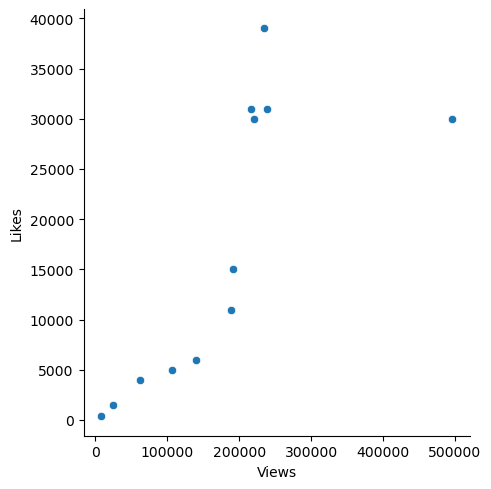

In [595]:
sns.relplot(x="Views",y="Likes", data=df);

### Generamos lineas al azar

Suponemos que la cantidad de likes es linealmente proporcional a la cantidad de vistas

In [596]:
#inicializo con valores aleatorios
b = 0.0
w = 0.1
#hago mi prediccion
def prediccion(x, w, b): 
    return w * x + b
#mi suma de los errores al cuadrado sera
def costo(x, w, b, y): 
    return np.sum((y - prediccion(x,w,b))**2)

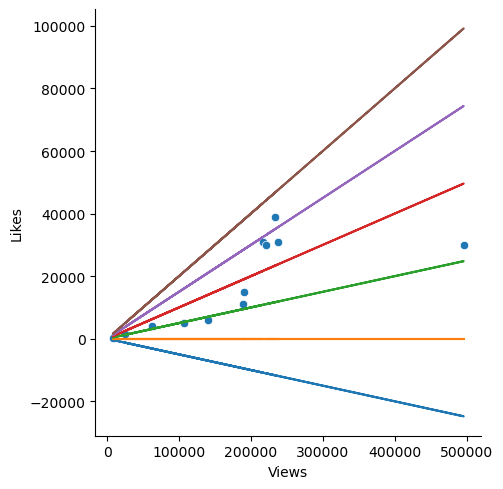

In [597]:
sns.relplot(x="Views",y="Likes", data=df)
pendientes = [-0.05,0.0,0.05,0.1,0.15,0.2]
costos = []
for w in pendientes:
    costos.append(costo(df["Views"], w, b, df["Likes"]))
    plt.plot(df["Views"], prediccion(df["Views"], w, b), '-');

### Calculamos los errores de cada linea que creamos

In [598]:
#tabla de la suma de errores para cada linea
df_costos = pd.DataFrame({"w":pendientes,"costo":costos})
df_costos

,w,costo
0,-0.05,1.220605e+10
1,0.00,5.668381e+09
2,0.05,1.936366e+09
3,0.10,1.010002e+09
4,0.15,2.889287e+09
5,0.20,7.574223e+09


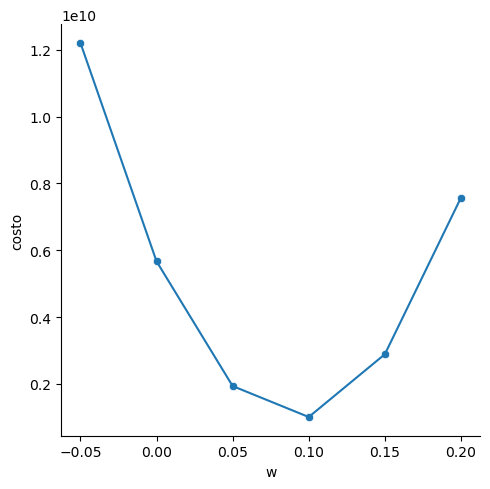

In [599]:
sns.relplot(x="w",y="costo", data=df_costos);
plt.plot(pendientes, costos, '-');

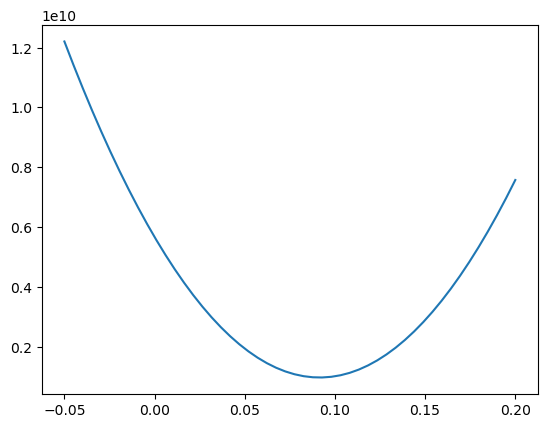

In [600]:
from scipy.interpolate import make_interp_spline, BSpline
xnew = np.linspace(np.min(pendientes), np.max(pendientes), 50) 
spl = make_interp_spline(pendientes, costos, k=3)
plt.plot(xnew, spl(xnew));

## El truco matematico del gradiente descendiente

La pendiente (derivada) nos dira en que direccion tenemos que buscar para encontrar el minimo

In [601]:
import sympy as sy

In [602]:
x,y,w,b = sy.symbols('x y w b')
costFunf = (y-(w*x+b))**2
costFunf

(-b - w*x + y)**2

In [603]:
sy.diff(costFunf,w)

-2*x*(-b - w*x + y)

In [604]:
sy.diff(costFunf,b)

2*b + 2*w*x - 2*y

In [605]:
del x,y,w,b

In [606]:
def gradW(x,y,w,b):
    grad = -2*x*(-b-w*x+y)
    grad = np.sum(grad)
    return grad

In [607]:
def gradb(x,y,w,b):
    grad = 2*b+2*w*x-2*y
    grad = np.sum(grad)
    return grad

### El algortimo del gradiente descendiente

In [638]:
x = np.array(df["Views"])
y = np.array(df["Likes"])
w = 0.2
b = 0.0
ws, cs = [], []
for i in range(20):
    ws.append(w)
    cost = costo(x, w, b, y)
    cs.append(cost)
    grad = gradW(x, y, w, b)
    print(f"w:{w:0.3f} cost:{int(cost):10}")
    #w = w - 0.0000000000003 * grad
    #w = w - 0.0000000000018 * grad
    w = w - 0.00000000000001 * grad

w:0.200 cost:7574222644
w:0.199 cost:7426811174
w:0.198 cost:7282689819
w:0.196 cost:7141785145
w:0.195 cost:7004025358
w:0.194 cost:6869340267
w:0.193 cost:6737661246
w:0.192 cost:6608921202
w:0.191 cost:6483054541
w:0.190 cost:6359997129
w:0.188 cost:6239686266
w:0.187 cost:6122060653
w:0.186 cost:6007060355
w:0.185 cost:5894626778
w:0.184 cost:5784702634
w:0.183 cost:5677231915
w:0.182 cost:5572159863
w:0.181 cost:5469432940
w:0.180 cost:5368998805
w:0.179 cost:5270806286


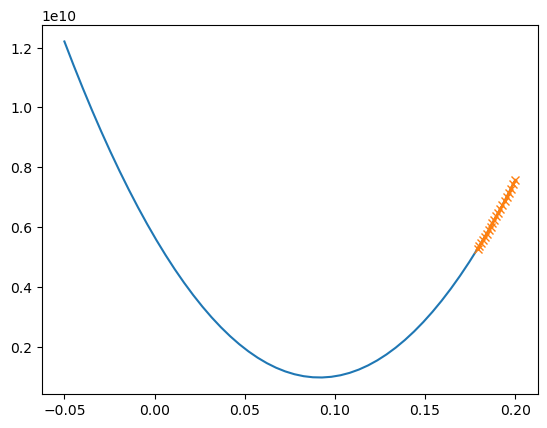

In [639]:
from scipy.interpolate import make_interp_spline, BSpline
xnew = np.linspace(np.min(pendientes), np.max(pendientes), 50) 
spl = make_interp_spline(pendientes, costos, k=3)
plt.plot(xnew, spl(xnew));
plt.plot(ws, cs, 'x-');

## Dos dimensiones

In [484]:
x = np.array(df["Views"])
y = np.array(df["Likes"])
w = 0.2
b = 0.0
for epoch in range(60):
    cost = costo(x, w, b, y)
    tmp_gradW = gradW(x, y, w, b)
    tmp_gradb = gradb(x, y, w, b)
    if epoch%5 == 0: print(f"w:{w:0.4f} b:{int(b):4} cost:{int(cost):10}")
    w = w - 0.000000000001 * tmp_gradW
    b = b - 0.03 * tmp_gradb

w:0.2000 b:   0 cost:7574222644
w:0.0936 b:-3824 cost:1182882644
w:0.0932 b: 485 cost: 968780228
w:0.0863 b:1423 cost: 951531737
w:0.0844 b:1958 cost: 948898121
w:0.0834 b:2165 cost: 948432137
w:0.0830 b:2256 cost: 948347957
w:0.0828 b:2294 cost: 948332709
w:0.0828 b:2311 cost: 948329947
w:0.0827 b:2318 cost: 948329446
w:0.0827 b:2321 cost: 948329355
w:0.0827 b:2322 cost: 948329339


## Con PyTorch

In [572]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F

In [583]:
x_data = Variable(torch.Tensor(x[..., None]))
x_data /= 100_000
y_data = Variable(torch.Tensor(y[..., None]))
y_data /= 10_000

In [584]:
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x):
        y_pred = self.linear(x) # X * W + b
        return y_pred
model = LinearRegression()

In [585]:
criterion = torch.nn.MSELoss()

In [586]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [587]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_data)
    # Compute Loss
    loss = criterion(y_pred, y_data)
    if epoch%10 == 0: print(f"costo:{loss}")
    # Backward pass
    loss.backward()
    optimizer.step()

costo:12.028946876525879
costo:2.1198785305023193
costo:1.0889321565628052
costo:0.9661704897880554
costo:0.937984049320221
costo:0.9211357235908508
costo:0.9069487452507019
costo:0.8943759799003601
costo:0.8831658363342285
costo:0.8731635212898254


In [588]:
new_x = Variable(torch.Tensor([[300_000/100_000]]))
y_pred = model(new_x)
print("predicted Y value: ", y_pred)

predicted Y value:  tensor([[2.6132]], grad_fn=<AddmmBackward0>)


In [589]:
y_pred.data[0][0] * 10_000

tensor(26132.4629)

In [590]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.6359]], requires_grad=True)
Parameter containing:
tensor([0.7056], requires_grad=True)


# Regresion Logistica

Utilizando la tecnica del gradiente descendiente en este ejemplo intentaremos adivinar si a una persona que le damos un prestamo nos devolvera el dinero

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
df = pd.DataFrame({"Salario":[1500,600,1800,700,1400,3100,2900,4200,5100,4500],
                  "Ahorro": [11000,5700,1500,7100,4900,11000,13000,14000,18000,16000],
                  "Devolvio":[0,0,0,0,0,1,1,1,1,1]})

In [16]:
df.head()

,Salario,Ahorro,Devolvio
0,1500,11000,0
1,600,5700,0
2,1800,1500,0
3,700,7100,0
4,1400,4900,0


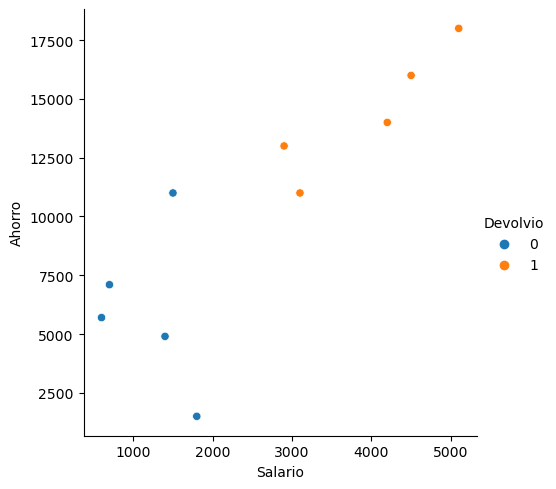

In [17]:
sns.relplot(x="Salario", y="Ahorro", hue="Devolvio", data=df);

In [158]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

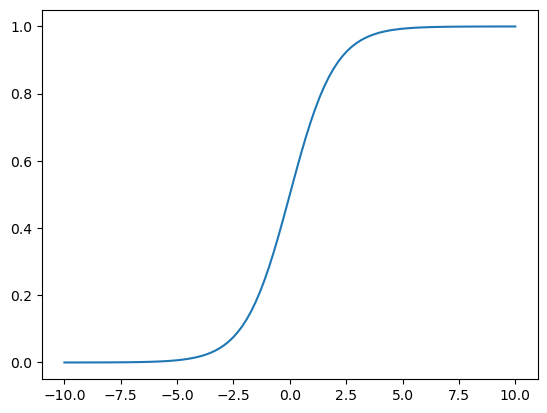

In [160]:
plt.plot(np.linspace(-10,10,100), sigmoid(np.linspace(-10,10,100)), '-');

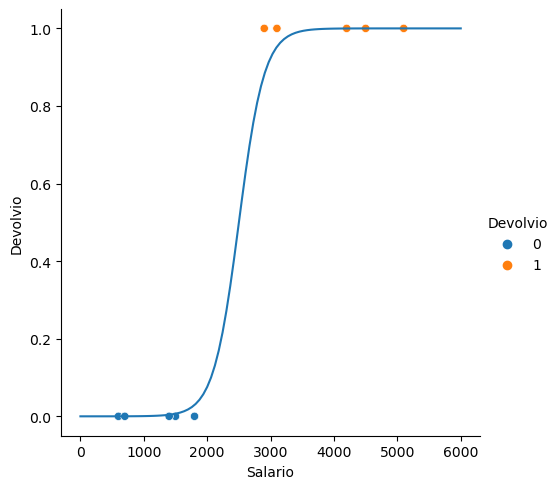

In [130]:
sns.relplot(x="Salario", y="Devolvio", hue="Devolvio", data=df);
plt.plot(np.linspace(0,6000,100), sigmoid(5*(np.linspace(0,6000,100)/1000-2.5)), '-');

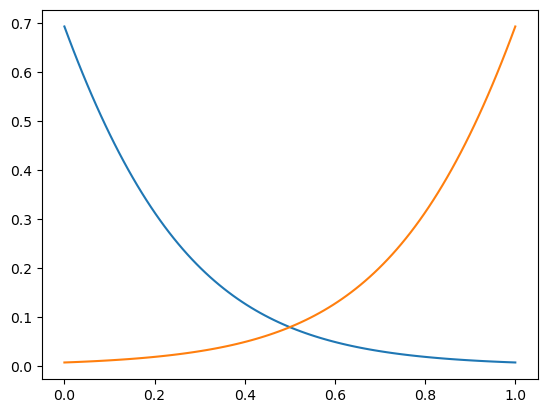

In [182]:
costoy1 = lambda x: -np.log(sigmoid(x))
plt.plot(np.linspace(0,1,100), costoy1(np.linspace(0,5,100)), '-');
costoy0 = lambda x: -np.log(1-sigmoid(x))
plt.plot(np.linspace(0,1,100), costoy0(np.linspace(-5,0,100)), '-');

## Con Scikit Learn

In [256]:
from sklearn.linear_model import LogisticRegression
X = df.loc[:,["Salario","Ahorro"]].to_numpy()
y = df.loc[:,"Devolvio"].to_numpy()
clf = LogisticRegression(random_state=0).fit(X, y)

In [257]:
clf.predict([[3_000,15_000]])

array([1])

In [258]:
clf.predict([[900,8_000]])

array([0])

## Con PyTorch

In [238]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F

In [246]:
x = df.loc[:,["Salario","Ahorro"]].to_numpy()
x[:,0] = x[:,0]/ 1000
x[:,1] = x[:,1]/ 10000
y = df.loc[:,["Devolvio"]].to_numpy()

In [247]:
x_data = Variable(torch.Tensor(x))
y_data = Variable(torch.Tensor(y))

In [248]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x)) # sigmoid(X * W + b)
        return y_pred
model = LogisticRegression()

In [249]:
criterion = torch.nn.BCELoss()

In [250]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [251]:
for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_data)
    # Compute Loss
    loss = criterion(y_pred, y_data)
    if epoch%100 == 0: print(f"costo:{loss}")
    # Backward pass
    loss.backward()
    optimizer.step()

costo:0.533144474029541
costo:0.2375362366437912
costo:0.1749037802219391
costo:0.14264510571956635
costo:0.12254415452480316


In [253]:
new_x = Variable(torch.Tensor([[3_000/1_000,15_000/10_000]]))
y_pred = model(new_x)
print("predicted Y value: ", y_pred)

predicted Y value:  tensor([[0.9673]], grad_fn=<SigmoidBackward0>)


In [254]:
new_x = Variable(torch.Tensor([[900/1_000,8_000/10_000]]))
y_pred = model(new_x)
print("predicted Y value: ", y_pred)

predicted Y value:  tensor([[0.2240]], grad_fn=<SigmoidBackward0>)


# Fin: [Volver al contenido del curso](https://www.freecodingtour.com/cursos/espanol/datascience/datascience.html)